In [1]:
from pathlib import Path
import pandas as pd

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# 🔁 nom du fichier brut (tel que dans ton dossier data)
RAW_FILE = "Export Max. journalier moy. hor. - 20251226130804 - 2017-08-17 00_00 - 2025-04-12 00_00.csv"

raw_path = DATA / RAW_FILE

# ---------- 1) chargement & nettoyage du fichier donneurs ----------
df_raw = pd.read_csv(raw_path, sep=";", engine="python")

# au cas où il y aurait plusieurs polluants, on sécurise
df_no2 = df_raw[df_raw["Polluant"] == "NO2"].copy()

# date + coordonnées
df_no2["date"] = pd.to_datetime(df_no2["Date de début"])
df_no2["lat"] = df_no2["Latitude"].astype(float)
df_no2["lon"] = df_no2["Longitude"].astype(float)

# mettre au format commun
new_donors = (
    df_no2.rename(columns={
        "code site": "station_id",
        "nom site": "station_name",
        "type d'implantation": "station_env",
        "type d'influence": "station_influence",
        "valeur": "no2_ug_m3",
    })[
        ["date",
         "station_id", "station_name",
         "station_env", "station_influence",
         "no2_ug_m3", "lat", "lon"]
    ]
    .sort_values(["station_id", "date"])
    .reset_index(drop=True)
)

print("Aperçu des nouvelles stations donneuses :")
display(new_donors[["station_id", "station_name",
                    "station_env", "station_influence"]].drop_duplicates())

# ---------- 2) sauvegarde standalone des donneurs ----------
donors_daily_path = DATA / "no2_donors_france_daily_clean.csv"
new_donors.to_csv(donors_daily_path, index=False)
print(f"✅ Donneurs nettoyés enregistrés dans : {donors_daily_path.name}")

# ---------- 3) mise à jour du gros fichier global des donneurs ----------
all_daily_path = DATA / "no2_all_stations_daily_clean.csv"

if all_daily_path.exists():
    all_daily = pd.read_csv(all_daily_path)
    all_daily["station_id"] = all_daily["station_id"].astype(str).str.strip()
else:
    all_daily = pd.DataFrame(columns=new_donors.columns)

new_donors["station_id"] = new_donors["station_id"].astype(str).str.strip()

combined = (
    pd.concat([all_daily, new_donors], ignore_index=True)
    .drop_duplicates(subset=["date", "station_id"])
    .sort_values(["station_id", "date"])
)

combined.to_csv(all_daily_path, index=False)
print(f"✅ Fichier global des donneurs mis à jour : {all_daily_path.name}")

# ---------- 4) mise à jour des métadonnées de stations ----------
donors_meta_new = (
    new_donors
    .groupby(["station_id", "station_name",
              "station_env", "station_influence"])[["lat", "lon"]]
    .first()
    .reset_index()
)

meta_path = DATA / "no2_stations_meta.csv"

if meta_path.exists():
    meta_old = pd.read_csv(meta_path)
else:
    meta_old = pd.DataFrame(columns=donors_meta_new.columns)

meta_all = (
    pd.concat([meta_old, donors_meta_new], ignore_index=True)
    .drop_duplicates(subset=["station_id"], keep="first")
)

meta_all.to_csv(meta_path, index=False)
print(f"✅ Métadonnées stations mises à jour : {meta_path.name}")


Aperçu des nouvelles stations donneuses :


,station_id,station_name,station_env,station_influence
0,FR01011,Metz-Centre,Urbaine,Fond
2759,FR03068,TOULON FOCH,Urbaine,Trafic
5525,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic
8308,FR08616,Nimes Planas,Urbaine,Trafic
8809,FR08616,Planas,Urbaine,Trafic
11088,FR16069,Mulhouse-Briand,Urbaine,Trafic
13881,FR19007,HALLES,Urbaine,Trafic
15108,FR19007,Rennes Les Halles,Urbaine,Trafic
16630,FR21001,Caen Chemin-Vert,Urbaine,Fond
19407,FR23120,BEAUX ARTS,Urbaine,Fond


✅ Donneurs nettoyés enregistrés dans : no2_donors_france_daily_clean.csv
✅ Fichier global des donneurs mis à jour : no2_all_stations_daily_clean.csv
✅ Métadonnées stations mises à jour : no2_stations_meta.csv


C:\Users\Pierre\AppData\Local\Temp\ipykernel_24252\2606868856.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([all_daily, new_donors], ignore_index=True)
C:\Users\Pierre\AppData\Local\Temp\ipykernel_24252\2606868856.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([meta_old, donors_meta_new], ignore_index=True)


Stations donneuses présentes :


,station_id,station_name,station_env,station_influence
19407,FR23120,BEAUX ARTS,Urbaine,Fond
24989,FR23188,CIM BOUTEILLERIE,Urbaine,Fond
16630,FR21001,Caen Chemin-Vert,Urbaine,Fond
27770,FR26014,Dijon Trémouille,Urbaine,Fond
33207,FR31001,GRAND PARC,Urbaine,Fond
22200,FR23174,GUEDOU,Urbaine,Fond
13881,FR19007,HALLES,Urbaine,Trafic
5525,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic
0,FR01011,Metz-Centre,Urbaine,Fond
11088,FR16069,Mulhouse-Briand,Urbaine,Trafic


Aperçu du panel mensuel donneurs :


,station_id,station_name,date,no2_ug_m3
0,FR01011,Metz-Centre,2017-08-01,40.100000
1,FR01011,Metz-Centre,2017-09-01,42.053333
2,FR01011,Metz-Centre,2017-10-01,46.732258
3,FR01011,Metz-Centre,2017-11-01,44.300000
4,FR01011,Metz-Centre,2017-12-01,38.019355


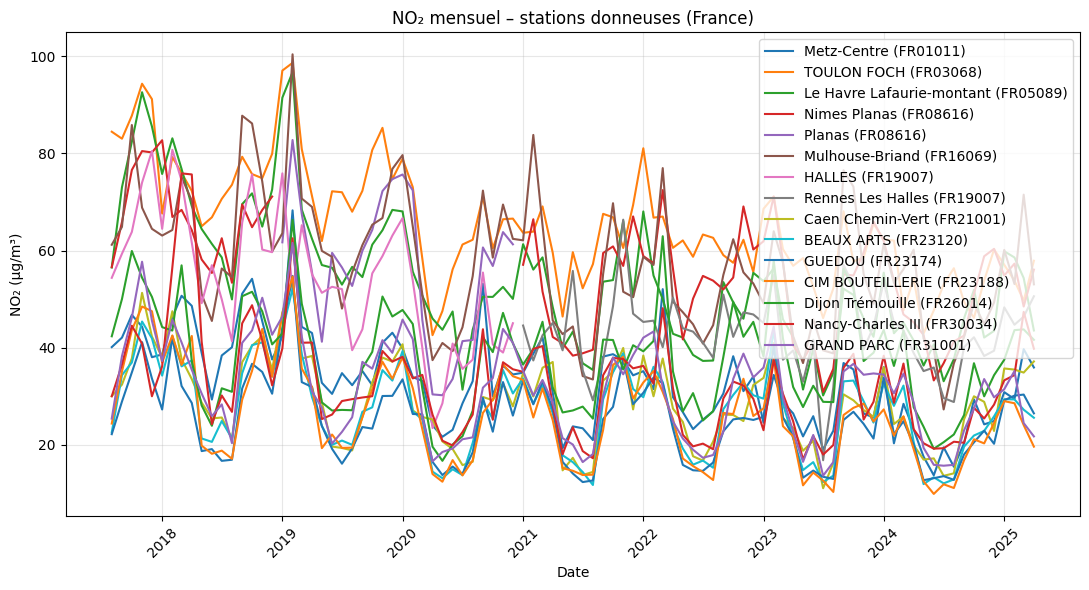

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# ---------- 1) charger les donneurs ----------
donors = pd.read_csv(DATA / "no2_donors_france_daily_clean.csv")
donors["date"] = pd.to_datetime(donors["date"])

print("Stations donneuses présentes :")
display(
    donors[["station_id", "station_name", "station_env", "station_influence"]]
    .drop_duplicates()
    .sort_values("station_name")
)

# ---------- 2) agrégation mensuelle ----------
monthly = (
    donors
    .set_index("date")
    .groupby(["station_id", "station_name"])["no2_ug_m3"]
    .resample("MS")          # MS = début de mois
    .mean()
    .reset_index()
)

print("Aperçu du panel mensuel donneurs :")
display(monthly.head())

# ---------- 3) tracé ----------
plt.figure(figsize=(11, 6))

for (sid, name), sub in monthly.groupby(["station_id", "station_name"]):
    plt.plot(sub["date"], sub["no2_ug_m3"], label=f"{name} ({sid})")

plt.title("NO₂ mensuel – stations donneuses (France)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
from pathlib import Path
import pandas as pd

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

donors_path = DATA / "no2_donors_france_daily_clean.csv"

donors = pd.read_csv(donors_path)
donors["date"] = pd.to_datetime(donors["date"])
donors["station_id"] = donors["station_id"].astype(str).str.strip()

print("Stations donneuses :")
display(
    donors[["station_id", "station_name", "station_env", "station_influence"]]
    .drop_duplicates()
    .sort_values("station_name")
)

# ---------- 1) détecter les valeurs manquantes par station ----------
gaps_rows = []
summary_rows = []

for sid, sub in donors.groupby("station_id"):
    name = sub["station_name"].iloc[0]
    
    sub = sub.sort_values("date").set_index("date")
    
    # recréer un index quotidien complet
    full_idx = pd.date_range(start=sub.index.min(), end=sub.index.max(), freq="D")
    sub_full = sub.reindex(full_idx)
    
    # True si valeur manquante (NaN ou jour absent)
    is_missing = sub_full["no2_ug_m3"].isna()
    total_missing = int(is_missing.sum())
    
    summary_rows.append({
        "station_id": sid,
        "station_name": name,
        "total_jours_manquants": total_missing,
        "date_min": sub_full.index.min(),
        "date_max": sub_full.index.max(),
    })
    
    if not is_missing.any():
        continue  # pas de trous pour cette station
    
    # trouver les intervalles consécutifs de True
    shifted_prev = is_missing.shift(1, fill_value=False)
    shifted_next = is_missing.shift(-1, fill_value=False)
    
    start_mask = is_missing & ~shifted_prev
    end_mask = is_missing & ~shifted_next
    
    starts = sub_full.index[start_mask]
    ends = sub_full.index[end_mask]
    
    for start, end in zip(starts, ends):
        length = (end - start).days + 1
        gaps_rows.append({
            "station_id": sid,
            "station_name": name,
            "gap_start": start,
            "gap_end": end,
            "gap_length_days": length,
        })

# ---------- 2) tableaux récap ----------
summary_df = pd.DataFrame(summary_rows).sort_values("total_jours_manquants", ascending=False)
gaps_df = pd.DataFrame(gaps_rows).sort_values(["station_id", "gap_start"])

print("Résumé des jours manquants par station :")
display(summary_df)

print("Intervalles de données manquantes (tous donneurs confondus) :")
display(gaps_df.head(50))  # tu peux enlever head(50) si tu veux tout voir

# Si tu veux les sauvegarder en CSV :
summary_df.to_csv(DATA / "no2_donors_missing_summary.csv", index=False)
gaps_df.to_csv(DATA / "no2_donors_missing_gaps.csv", index=False)

print("✅ Sauvegardé :")
print(" - no2_donors_missing_summary.csv")
print(" - no2_donors_missing_gaps.csv")


Stations donneuses :


,station_id,station_name,station_env,station_influence
19407,FR23120,BEAUX ARTS,Urbaine,Fond
24989,FR23188,CIM BOUTEILLERIE,Urbaine,Fond
16630,FR21001,Caen Chemin-Vert,Urbaine,Fond
27770,FR26014,Dijon Trémouille,Urbaine,Fond
33207,FR31001,GRAND PARC,Urbaine,Fond
22200,FR23174,GUEDOU,Urbaine,Fond
13881,FR19007,HALLES,Urbaine,Trafic
5525,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic
0,FR01011,Metz-Centre,Urbaine,Fond
11088,FR16069,Mulhouse-Briand,Urbaine,Trafic


Résumé des jours manquants par station :


,station_id,station_name,total_jours_manquants,date_min,date_max
11,FR30034,Nancy-Charles III,87,2017-08-17,2025-04-11
10,FR26014,Dijon Trémouille,66,2017-08-17,2025-04-11
5,FR19007,HALLES,46,2017-08-17,2025-04-11
0,FR01011,Metz-Centre,36,2017-08-17,2025-04-11
12,FR31001,GRAND PARC,30,2017-08-17,2025-04-11
1,FR03068,TOULON FOCH,29,2017-08-17,2025-04-11
3,FR08616,Nimes Planas,15,2017-08-17,2025-04-11
6,FR21001,Caen Chemin-Vert,14,2017-08-21,2025-04-11
9,FR23188,CIM BOUTEILLERIE,14,2017-08-17,2025-04-11
2,FR05089,Le Havre Lafaurie-montant,12,2017-08-17,2025-04-11


Intervalles de données manquantes (tous donneurs confondus) :


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR01011,Metz-Centre,2023-02-23,2023-02-23,1
1,FR01011,Metz-Centre,2023-03-28,2023-03-28,1
2,FR01011,Metz-Centre,2023-11-11,2023-11-16,6
3,FR01011,Metz-Centre,2023-12-28,2024-01-24,28
4,FR03068,TOULON FOCH,2018-02-18,2018-02-18,1
5,FR03068,TOULON FOCH,2018-10-21,2018-10-21,1
6,FR03068,TOULON FOCH,2018-11-29,2018-11-29,1
7,FR03068,TOULON FOCH,2019-06-16,2019-06-16,1
8,FR03068,TOULON FOCH,2019-11-08,2019-11-12,5
9,FR03068,TOULON FOCH,2019-11-26,2019-11-27,2


✅ Sauvegardé :
 - no2_donors_missing_summary.csv
 - no2_donors_missing_gaps.csv


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent
DATA = ROOT / "data"

donors_daily = pd.read_csv(DATA / "no2_donors_france_daily_clean.csv")
donors_daily["date"] = pd.to_datetime(donors_daily["date"])
donors_daily["station_id"] = donors_daily["station_id"].astype(str).str.strip()

# garder la méta (nom de station, type, coords)
meta = donors_daily[[
    "station_id", "station_name",
    "station_env", "station_influence",
    "lat", "lon"
]].drop_duplicates()

# ---------- 1) agrégation mensuelle (mean + nb de jours dispo) ----------
monthly = (
    donors_daily
    .set_index("date")
    .groupby("station_id")["no2_ug_m3"]
    .resample("MS")              # début de mois
    .agg(["mean", "count"])
    .reset_index()
)

# pivot large
mean_wide = monthly.pivot(index="date", columns="station_id", values="mean")
count_wide = monthly.pivot(index="date", columns="station_id", values="count")

# ---------- 2) on impose un minimum de jours dans le mois ----------
min_days = 10  # tu peux ajuster à 5, 15, etc.
mean_wide[count_wide < min_days] = np.nan

print("Nb de mois manquants par station AVANT imputation :")
missing_before = mean_wide.isna().sum()
display(missing_before.to_frame("nb_mois_na").sort_values("nb_mois_na", ascending=False))

# ---------- 3) interpolation temporelle par station ----------
mean_interp = mean_wide.interpolate(limit_direction="both")

print("Nb de mois manquants par station APRES imputation :")
missing_after = mean_interp.isna().sum()
display(missing_after.to_frame("nb_mois_na").sort_values("nb_mois_na", ascending=False))

# (optionnel) virer les stations vraiment trop pourries
max_missing_allowed = 12  # ex : tu acceptes au plus 12 mois manquants sur toute la période
good_stations = missing_before[missing_before <= max_missing_allowed].index.tolist()
mean_interp = mean_interp[good_stations]

print("Stations conservées après filtrage :", good_stations)

# ---------- 4) repasser en long + sauvegarde ----------
monthly_long = (
    mean_interp
    .reset_index()
    .melt(id_vars="date", var_name="station_id", value_name="no2_ug_m3")
    .dropna(subset=["no2_ug_m3"])
)

# join avec la méta
monthly_long = monthly_long.merge(meta, on="station_id", how="left")

monthly_path = DATA / "no2_donors_france_monthly_imputed.csv"
monthly_long.to_csv(monthly_path, index=False)

print("✅ Fichier donneurs mensuel imputé enregistré dans :", monthly_path.name)
display(monthly_long.head())


Nb de mois manquants par station AVANT imputation :


,nb_mois_na
station_id,
FR01011,1
FR31001,1
FR03068,0
FR08616,0
FR05089,0
FR16069,0
FR19007,0
FR23120,0
FR21001,0


Nb de mois manquants par station APRES imputation :


,nb_mois_na
station_id,
FR01011,0
FR03068,0
FR05089,0
FR08616,0
FR16069,0
FR19007,0
FR21001,0
FR23120,0
FR23174,0


Stations conservées après filtrage : ['FR01011', 'FR03068', 'FR05089', 'FR08616', 'FR16069', 'FR19007', 'FR21001', 'FR23120', 'FR23174', 'FR23188', 'FR26014', 'FR30034', 'FR31001']
✅ Fichier donneurs mensuel imputé enregistré dans : no2_donors_france_monthly_imputed.csv


,date,station_id,no2_ug_m3,station_name,station_env,station_influence,lat,lon
0,2017-08-01,FR01011,40.100000,Metz-Centre,Urbaine,Fond,49.119442,6.180833
1,2017-09-01,FR01011,42.053333,Metz-Centre,Urbaine,Fond,49.119442,6.180833
2,2017-10-01,FR01011,46.732258,Metz-Centre,Urbaine,Fond,49.119442,6.180833
3,2017-11-01,FR01011,44.300000,Metz-Centre,Urbaine,Fond,49.119442,6.180833
4,2017-12-01,FR01011,38.019355,Metz-Centre,Urbaine,Fond,49.119442,6.180833


Stations Paris :


,station_id,station_name
0,FR04031,Av Champs Elysees
3015,FR04055,PARIS 1er Les Halles


Stations donneuses utilisées :


,station_id,station_name,station_env,station_influence
837,FR23120,BEAUX ARTS,Urbaine,Fond
1023,FR23188,CIM BOUTEILLERIE,Urbaine,Fond
744,FR21001,Caen Chemin-Vert,Urbaine,Fond
1116,FR26014,Dijon Trémouille,Urbaine,Fond
1302,FR31001,GRAND PARC,Urbaine,Fond
930,FR23174,GUEDOU,Urbaine,Fond
558,FR19007,HALLES,Urbaine,Trafic
186,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic
0,FR01011,Metz-Centre,Urbaine,Fond
465,FR16069,Mulhouse-Briand,Urbaine,Trafic


Début ZFE Paris (d'après zfe_meta) : 2021-06-01
Station traitée : Av Champs Elysees (FR04031)
Période du panel : 2017-08-01 → 2024-12-01
Nombre de donneurs utilisés : 13
Ridge – alpha* = 1000.0000
Lasso – alpha* = 4.7149
ElasticNet – alpha* = 7.8965, l1_ratio* = 0.50
RMSE pré-ZFE (ridge) : 5.620
RMSE pré-ZFE (lasso) : 5.705
RMSE pré-ZFE (elasticnet) : 5.708


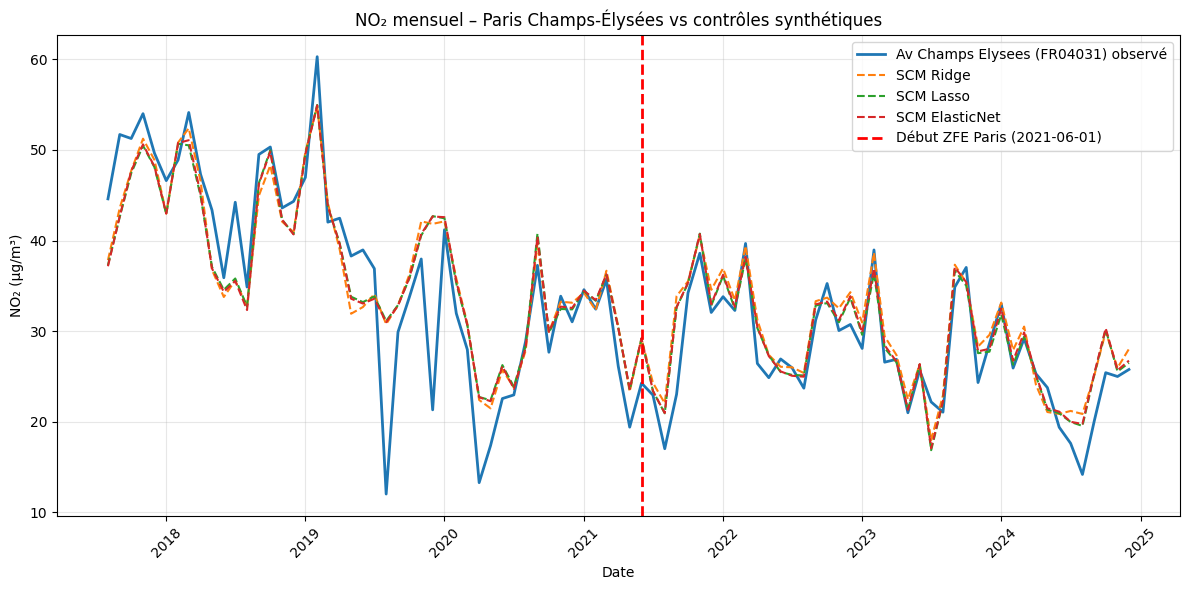

<Figure size 1200x600 with 0 Axes>

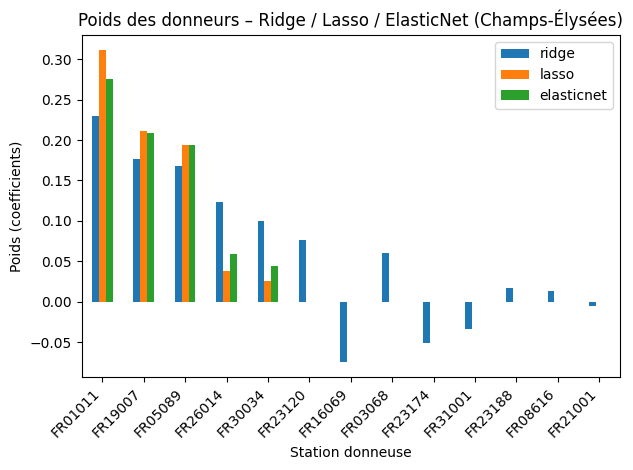

,ridge,lasso,elasticnet
station_id,,,
FR01011,0.229512,0.310747,0.275368
FR19007,0.177081,0.211104,0.209156
FR05089,0.168272,0.193419,0.193670
FR26014,0.123523,0.038555,0.059061
FR30034,0.099514,0.026393,0.043717
FR23120,0.076356,0.000000,0.000000
FR16069,-0.073706,-0.000000,-0.000000
FR03068,0.059903,0.000000,0.000000
FR23174,-0.051379,-0.000000,-0.000000


In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

# =============================
# 0. Chemins & chargement
# =============================
HERE = Path().resolve()      # dossier zfe-scm
ROOT = HERE.parent
DATA = ROOT / "data"

# Paris (toutes stations)
paris_daily = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
paris_daily["date"] = pd.to_datetime(paris_daily["date"])
paris_daily["station_id"] = paris_daily["station_id"].astype(str).str.strip()

print("Stations Paris :")
display(paris_daily[["station_id", "station_name"]].drop_duplicates())

# Donneurs mensuels imputés
donors_monthly = pd.read_csv(DATA / "no2_donors_france_monthly_imputed.csv")
donors_monthly["date"] = pd.to_datetime(donors_monthly["date"])
donors_monthly["station_id"] = donors_monthly["station_id"].astype(str).str.strip()

print("Stations donneuses utilisées :")
display(
    donors_monthly[["station_id", "station_name", "station_env", "station_influence"]]
    .drop_duplicates()
    .sort_values("station_name")
)

# Meta ZFE pour la date de traitement Paris
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
paris_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "PARIS"].iloc[0]
zfe_start = pd.to_datetime(paris_row["first_date_debut"])
zfe_start_month = zfe_start.to_period("M").to_timestamp()
print("Début ZFE Paris (d'après zfe_meta) :", zfe_start.date())

# =============================
# 1. Station traitée = Champs-Élysées
# =============================

treated_df = paris_daily[
    paris_daily["station_name"].str.lower().str.contains("champs", na=False)
].copy()

if treated_df.empty:
    treated_df = paris_daily[
        paris_daily["station_name"].str.lower().str.contains("elys", na=False)
    ].copy()

if treated_df.empty:
    raise ValueError("Impossible de trouver la station Champs-Élysées dans pollution_paris_no2_daily_clean.csv")

treated_id = treated_df["station_id"].iloc[0]
treated_name = treated_df["station_name"].iloc[0]

print(f"Station traitée : {treated_name} ({treated_id})")

treated_monthly = (
    treated_df
    .set_index("date")["no2_ug_m3"]
    .resample("MS")
    .mean()
)

# =============================
# 2. Panel mensuel donneurs (on sécurise les doublons)
# =============================

donors_monthly_agg = (
    donors_monthly
    .groupby(["date", "station_id"], as_index=False)["no2_ug_m3"]
    .mean()
)

donors_wide = (
    donors_monthly_agg
    .pivot(index="date", columns="station_id", values="no2_ug_m3")
    .sort_index()
)

# =============================
# 3. Construction du panel (traitée + donneurs)
# =============================

panel = donors_wide.copy()
panel["treated"] = treated_monthly
panel = panel.dropna(subset=["treated"])

start = pd.to_datetime("2017-08-01")
end   = pd.to_datetime("2024-12-01")
panel = panel.loc[(panel.index >= start) & (panel.index <= end)]

donor_matrix = panel.drop(columns=["treated"]).copy()
donor_matrix = donor_matrix.interpolate(limit_direction="both")
donor_matrix = donor_matrix.dropna(axis=1, how="all")

donor_ids = donor_matrix.columns.tolist()
treated_series = panel["treated"]

print("Période du panel :", treated_series.index.min().date(), "→", treated_series.index.max().date())
print("Nombre de donneurs utilisés :", len(donor_ids))

pre_mask = treated_series.index < zfe_start_month
post_mask = treated_series.index >= zfe_start_month

X_pre = donor_matrix.loc[pre_mask]
y_pre = treated_series.loc[pre_mask]
X_all = donor_matrix

# =============================
# 4. Fonctions SCM
# =============================

def fit_ridge(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 3, 50)
    model = RidgeCV(alphas=alphas, cv=5, fit_intercept=False)
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="ridge")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="ridge")
    return y_hat, weights, model.alpha_

def fit_lasso(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 1, 50)
    model = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=10000)
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="lasso")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="lasso")
    return y_hat, weights, model.alpha_

def fit_elasticnet(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 1, 40)
    l1s = [0.1, 0.5, 0.9]
    model = ElasticNetCV(
        alphas=alphas,
        l1_ratio=l1s,
        cv=5,
        fit_intercept=False,
        max_iter=10000,
    )
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="elasticnet")
    weights = pd.Series(model.coef_, index=X_all.columns, name="elasticnet")
    return y_hat, weights, (model.alpha_, model.l1_ratio_)

# =============================
# 5. Ajustements Ridge / Lasso / ElasticNet
# =============================

y_ridge, w_ridge, alpha_ridge = fit_ridge(X_pre, y_pre, X_all)
y_lasso, w_lasso, alpha_lasso = fit_lasso(X_pre, y_pre, X_all)
y_en, w_en, (alpha_en, l1_en) = fit_elasticnet(X_pre, y_pre, X_all)

print(f"Ridge – alpha* = {alpha_ridge:.4f}")
print(f"Lasso – alpha* = {alpha_lasso:.4f}")
print(f"ElasticNet – alpha* = {alpha_en:.4f}, l1_ratio* = {l1_en:.2f}")

for name, y_syn in [("ridge", y_ridge), ("lasso", y_lasso), ("elasticnet", y_en)]:
    mse_pre = mean_squared_error(
        treated_series[pre_mask],
        y_syn[pre_mask],
    )
    rmse_pre = mse_pre ** 0.5
    print(f"RMSE pré-ZFE ({name}) : {rmse_pre:.3f}")

# =============================
# 6. Graphique série temporelle
# =============================

plt.figure(figsize=(12, 6))

plt.plot(treated_series.index, treated_series.values,
         label=f"{treated_name} ({treated_id}) observé", linewidth=2)

plt.plot(y_ridge.index, y_ridge.values, label="SCM Ridge", linestyle="--")
plt.plot(y_lasso.index, y_lasso.values, label="SCM Lasso", linestyle="--")
plt.plot(y_en.index, y_en.values, label="SCM ElasticNet", linestyle="--")

plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Paris ({zfe_start_month.date()})")

plt.title("NO₂ mensuel – Paris Champs-Élysées vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================
# 7. Graphique des poids
# =============================

weights_df = pd.concat([w_ridge, w_lasso, w_en], axis=1).fillna(0.0)
weights_df.index.name = "station_id"

weights_df["mean_abs"] = weights_df.abs().mean(axis=1)
weights_df = weights_df.sort_values("mean_abs", ascending=False)
weights_df = weights_df.drop(columns=["mean_abs"])

plt.figure(figsize=(12, 6))
weights_df.plot(kind="bar")
plt.title("Poids des donneurs – Ridge / Lasso / ElasticNet (Champs-Élysées)")
plt.xlabel("Station donneuse")
plt.ylabel("Poids (coefficients)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

weights_df


Résumé des ATT (en µg/m³) – Paris Champs-Élysées :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ridge,-0.241834,-1.901683,-1.831109
1,Lasso,-0.265931,-1.132788,-1.042224
2,ElasticNet,-0.251554,-1.296150,-1.208893


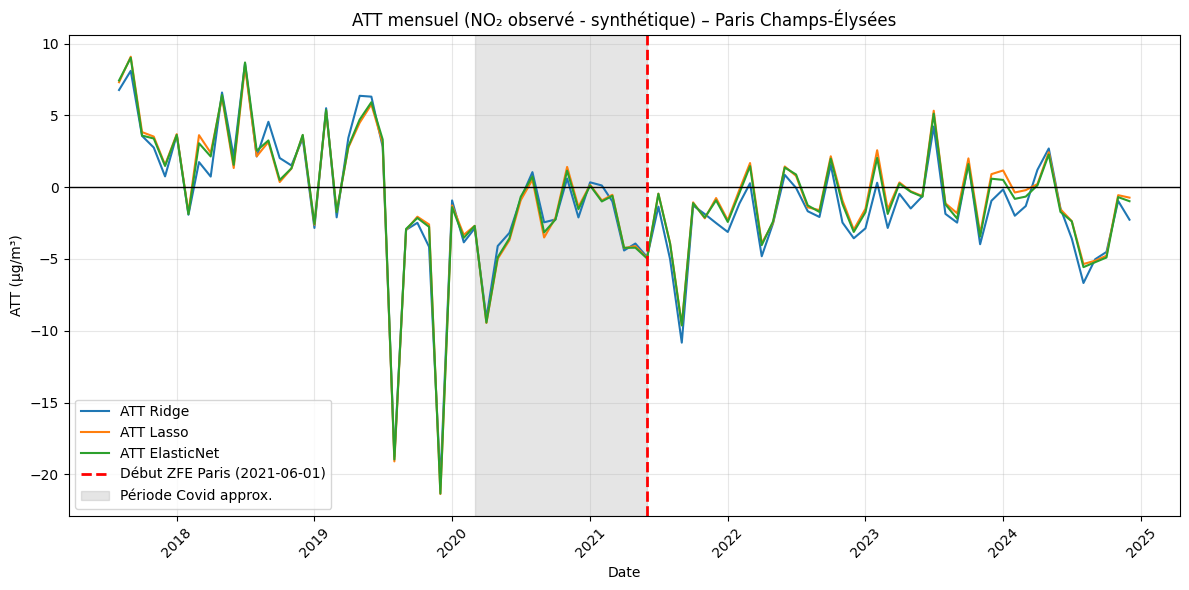

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# ATT SCM – Paris Champs-Élysées
# =============================

# 1) Construire les séries ATT_t = obs - synth
synth_dict = {
    "Ridge": y_ridge,
    "Lasso": y_lasso,
    "ElasticNet": y_en,
}

att_dict = {}
for name, y_hat in synth_dict.items():
    # aligner proprement les dates
    common_idx = treated_series.index.intersection(y_hat.index)
    att = treated_series.loc[common_idx] - y_hat.loc[common_idx]
    att.name = f"ATT_{name}"
    att_dict[name] = att

# 2) Masques temporels (global)
dates = treated_series.index
covid_start = pd.to_datetime("2020-03-01")
covid_end   = pd.to_datetime("2021-06-01")

# 3) Tableau récapitulatif des ATT moyens
rows = []
for name, att in att_dict.items():
    idx = att.index
    pre = idx < zfe_start_month
    post = idx >= zfe_start_month
    covid = (idx >= covid_start) & (idx <= covid_end)
    post_nocovid = post & ~covid

    rows.append({
        "méthode": name,
        "ATT_moy_pre": att[pre].mean(),
        "ATT_moy_post": att[post].mean(),
        "ATT_moy_post_sans_Covid": att[post_nocovid].mean(),
    })

att_summary = pd.DataFrame(rows)
print("Résumé des ATT (en µg/m³) – Paris Champs-Élysées :")
display(att_summary)

# 4) Graphique des ATT dans le temps
plt.figure(figsize=(12, 6))

for name, att in att_dict.items():
    plt.plot(att.index, att.values, label=f"ATT {name}")

plt.axhline(0, color="black", linewidth=1)
plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Paris ({zfe_start_month.date()})")

# zone Covid en gris
plt.axvspan(covid_start, covid_end, color="grey", alpha=0.2, label="Période Covid approx.")

plt.title("ATT mensuel (NO₂ observé - synthétique) – Paris Champs-Élysées")
plt.xlabel("Date")
plt.ylabel("ATT (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
